In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer




from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score,roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler,LabelBinarizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten, Embedding, LSTM, GRU
from tensorflow.keras.utils import to_categorical
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

tfidf = TfidfVectorizer(stop_words=set(stopwords.words('english')),max_features=500)
sid = SentimentIntensityAnalyzer()
scaler = StandardScaler()
lb = LabelBinarizer()
from sklearn.utils import class_weight



In [3]:
train_df = pd.read_csv("..\Datasets\Ecommerce\\train_data.csv")
test_df = pd.read_csv("..\Datasets\Ecommerce\\test_data.csv")
test_val_df = pd.read_csv("..\Datasets\Ecommerce\\test_data_hidden.csv")
train_df.shape,test_df.shape

((4000, 8), (1000, 7))

In [4]:
train_df.duplicated().sum(), test_df.duplicated().sum(), test_val_df.duplicated().sum()

(58, 3, 3)

In [5]:
train_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [6]:
train_df.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [7]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [8]:
test_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,purchased for my grandson. He loves it. When s...,Great tablet
freq,169,1000,169,676,26,2,22


In [9]:
test_val_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [10]:
test_val_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,997,1000
unique,23,1,23,4,366,979,796,3
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,purchased for my grandson. He loves it. When s...,Great tablet,Positive
freq,169,1000,169,676,26,2,22,937


In [11]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [12]:
test_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

In [13]:
train_df["sentiment"].value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

In [14]:
Positive_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Positive"]["reviews.text"]:
  Positive_Review_Text += " " +review.lower()

Negative_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Negative"]["reviews.text"]:
  Negative_Review_Text += " " +review.lower()

Neutral_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Neutral"]["reviews.text"]:
  Neutral_Review_Text += " " +review.lower()


In [15]:
class WordCloudGeneration:
    def preprocessing(self, data):
        data = data.split(".")
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        return preprocessed_data

    def create_word_cloud(self, final_data,title=""):
        final_data=self.preprocessing(final_data)

        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(final_data)
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title,fontsize=40)
        plt.show()

        
wordcloud_generator = WordCloudGeneration()

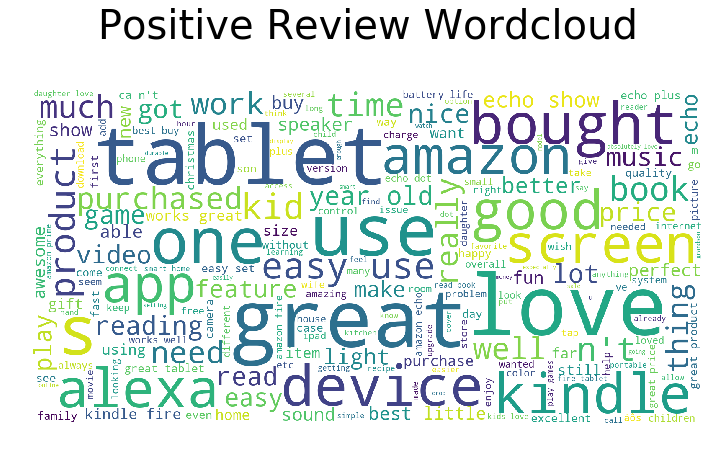

In [16]:

wordcloud_generator.create_word_cloud(Positive_Review_Text,"Positive Review Wordcloud\n")

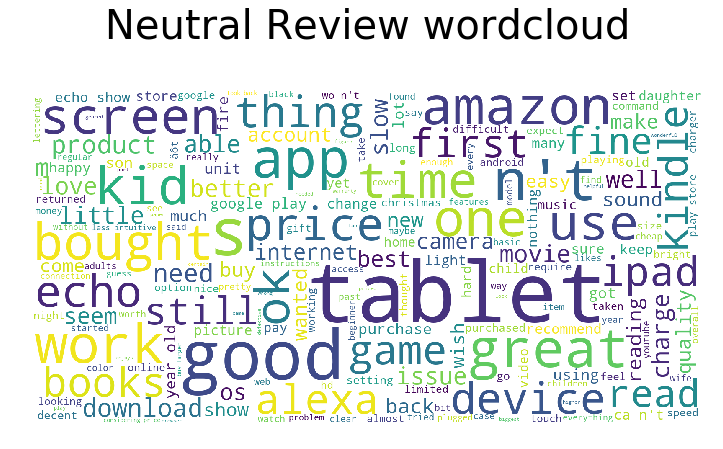

In [17]:
wordcloud_generator.create_word_cloud(Neutral_Review_Text,"Neutral Review wordcloud\n")

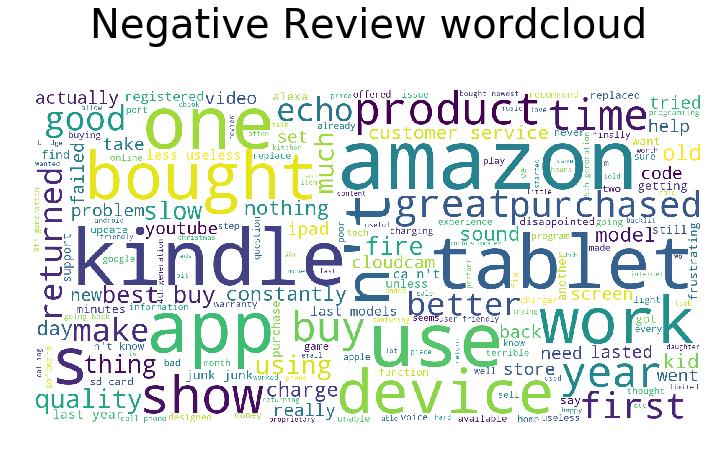

In [18]:
wordcloud_generator.create_word_cloud(Negative_Review_Text,"Negative Review wordcloud\n")

# Observations 

Duplicates found in all datasets


Only one brand. - brand column can be dropped:

name, categories, primaryCategories, and sentiment are categorical:
**LabelEncoder**

reviews.date to be converted to DateTime (Drop or not?):

reviews.text and reviews.title are text:
**TFIDF**
**Sentiment Analysis**

null values in reviews.title:


class imbalance issue:
**undersampling**
**oversampling**
**class weights**



# Tasks based on observations

Remove Duplicates

In [19]:
train_df=train_df[train_df.duplicated()==False]
test_df=test_df[test_df.duplicated()==False]
test_val_df=test_val_df[test_val_df.duplicated()==False]

train_df.reset_index(inplace=True)
test_val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

fill null values

In [20]:
train_df['reviews.title'].fillna(value='',inplace=True)
test_val_df['reviews.title'].fillna(value=' ',inplace=True)
test_df['reviews.title'].fillna(value=' ',inplace=True)

Drop Brand Category

In [21]:
train_df.drop("brand",inplace=True,axis=1)
test_df.drop("brand",inplace=True,axis=1)
test_val_df.drop("brand",inplace=True,axis=1)

Encode categories

In [22]:
def to_labels(series):
  le=LabelEncoder()
  return le.fit_transform(series)

categories = ["name","categories","primaryCategories","sentiment"]

for cat in categories:
  train_df[cat]=to_labels(train_df[cat])
  test_val_df[cat]=to_labels(test_val_df[cat])
  if not cat=="sentiment":
    test_df[cat]=to_labels(test_df[cat])


train_df.shape,test_df.shape,test_val_df.shape

((3942, 8), (997, 7), (997, 8))

Vectorize text with Tfidf

In [23]:

lemmatizer = WordNetLemmatizer()
def get_tfidf(series):
    print("Calclating tfidf")

    new_series=[]
    for review in series:
        toks = word_tokenize(review)
        toks_sans_stopwords = [word for word in toks if not word in set(stopwords.words('english'))]
        review_lemma = lemmatizer.lemmatize(" ".join(toks_sans_stopwords))
        new_series.append(review_lemma)
    result=pd.DataFrame(tfidf.fit_transform(new_series).toarray())
    print("calculation complete")
    return result

In [24]:
def get_sentiment_scores(df):
    print("Calclating Polarity Scores - Reviews.text")
    df["reviews.text_scores"] = np.array(df["reviews.text"].map(lambda x: sid.polarity_scores(x)))
    print("Calclating Polarity Scores - Reviews.titl")
    df["reviews.title_scores"] = np.array(df["reviews.title"].map(lambda x: sid.polarity_scores(x)))
    neg=[]
    neu=[]
    pos=[]
    for scores in df["reviews.text_scores"]:
        neg.append(scores["neg"])
        neu.append(scores["neu"])
        pos.append(scores["pos"])
    df["reviews_text_neg"] = np.array(neg)
    df["reviews_text_neu"] = np.array(neu)
    df["reviews_text_pos"] = np.array(pos)
    df.drop(["reviews.text_scores","reviews.title_scores"],axis=1,inplace=True)
    
    print("Calclating Polarity Scores - Complete")



In [25]:
get_sentiment_scores(train_df)
get_sentiment_scores(test_df)
get_sentiment_scores(test_val_df)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)

train_df.shape,test_df.shape,test_val_df.shape

Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete


((3942, 1009), (997, 1008), (997, 1009))

In [26]:

train_df['reviews.date'] = train_df['reviews.date'].str.split('T').str[0]
test_val_df['reviews.date'] = test_val_df['reviews.date'].str.split('T').str[0]
test_df['reviews.date'] = test_df['reviews.date'].str.split('T').str[0]

train_df['reviews_day'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.day
train_df['reviews_month'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.month
train_df['reviews_year'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.year

test_val_df['reviews_day'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.day
test_val_df['reviews_month'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.month
test_val_df['reviews_year'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.year

test_df['reviews_day'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.day
test_df['reviews_month'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.month
test_df['reviews_year'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.year


In [27]:

X_train = np.array(train_df.drop(["sentiment","reviews.date","index"],axis=1))


y_train = np.array(train_df["sentiment"])
y_test = np.array(test_val_df["sentiment"])

X_test = np.array(test_val_df.drop(["reviews.date","sentiment","index"],axis=1))
print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

(997, 1009) (997,) (3942, 1009) (3942,)


In [28]:
test_val_df.drop(["reviews.date","index"],axis=1, inplace=True)

# Multinomial Naive Bayes Classification

In [29]:
model = MultinomialNB()

In [30]:
model.fit(X_train,y_train)

MultinomialNB()

In [31]:
def show_metrics(true_vals,pred_vals):
    print(pd.DataFrame(confusion_matrix(true_vals,pred_vals),columns=["negative","neutral","positive"],index=["negative","neutral","positive"]))
    print("\n")
    print(classification_report(true_vals,pred_vals))
    show_roc(true_vals,pred_vals)

def show_roc(y_val,y_pred):
    lb.fit(y_val)
    y_val1 = lb.transform(y_val)
    y_pred1 = lb.transform(y_pred)
    print(roc_auc_score(y_val1, y_pred1, average='weighted'))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    lw=2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve of class Model (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of current Model')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
preds=model.predict(X_test)

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0       22       912


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      0.98      0.96       934

    accuracy                           0.91       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.91      0.90       997

0.48851774530271397


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


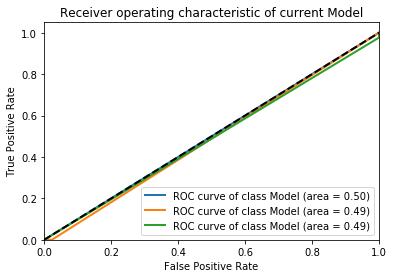

In [38]:
show_metrics(y_test,preds)

# Dealing with class Imbalance

In [33]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [44]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights={0:class_weights[0],1:class_weights[1],2:class_weights[2]}


In [45]:
oversample=RandomOverSampler(sampling_strategy="not majority")
undersample=RandomUnderSampler(sampling_strategy="not minority")

# oversample/undersample

[Voting] ..................... (1 of 3) Processing FRST, total=   0.2s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.9s finished
C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[Voting] ....................... (2 of 3) Processing LR, total=   8.1s
[10:55:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "learing_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[Voting] ...................... (3 of 3) Processing xgb, total=   4.7s
          negative  neutral  positive
negative        19        3         2
neutral         21        8        10
positive       180      218       536


              precision    recall  f1-score   support

           0       0.09      0.79      0.16        24
           1       0.03      0.21      0.06        39
           2       0.98      0.57      0.72       934

    accuracy                           0.56       997
   macro avg       0.37      0.52      0.31       997
weighted avg   

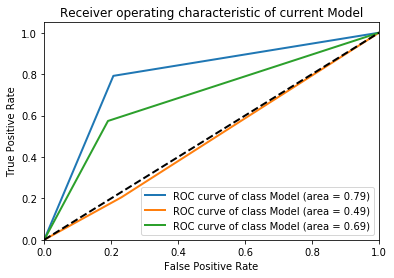

In [52]:
steps = [('u', undersample),
         ('model', VotingClassifier([
             ("FRST",RandomForestClassifier(class_weight='balanced')),
             ("LR",LogisticRegression(C=30, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', random_state=40, 
                         verbose=1, max_iter=1000, n_jobs=4)),
                         ("xgb", XGBClassifier(n_estimators=1000,max_depth=6, eval_metric=["auc","error"], learing_rate=.001))
             ],verbose=True))]

pipeline = Pipeline(steps=steps)

pipeline.fit(X_train,y_train)

preds = pipeline.predict(X_test)

show_metrics(y_test,preds)

In [53]:
models=[
        LogisticRegression(class_weight='balanced'),
        # SVC(class_weight='balanced'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        # MultinomialNB(),
        XGBClassifier(n_estimators=1000,max_depth=6, eval_metric=["auc","error"], verbose=True, learning_rate=.001)
        ]


LogisticRegression(class_weight='balanced')  -- control 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          negative  neutral  positive
negative        14        5         5
neutral         13       12        14
positive       257      289       388


              precision    recall  f1-score   support

           0       0.05      0.58      0.09        24
           1       0.04      0.31      0.07        39
           2       0.95      0.42      0.58       934

    accuracy                           0.42       997
   macro avg       0.35      0.44      0.25       997
weighted avg       0.90      0.42      0.55       997

0.5570155268567728


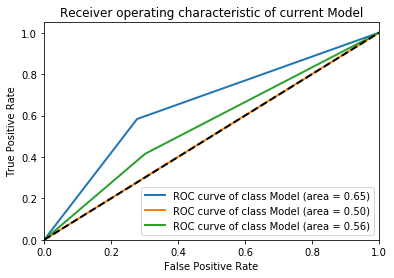

DecisionTreeClassifier(class_weight='balanced')  -- control 
 ************************************************** 

          negative  neutral  positive
negative         9        3        12
neutral          9        4        26
positive        70       57       807


              precision    recall  f1-score   support

           0       0.10      0.38      0.16        24
           1       0.06      0.10      0.08        39
           2       0.96      0.86      0.91       934

    accuracy                           0.82       997
   macro avg       0.37      0.45      0.38       997
weighted avg       0.90      0.82      0.86       997

0.6265013637762621


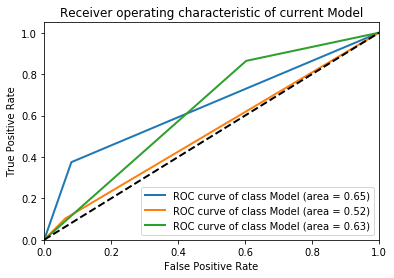

RandomForestClassifier(class_weight='balanced')  -- control 
 ************************************************** 

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0        0       934


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.94      0.91       997

0.5


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


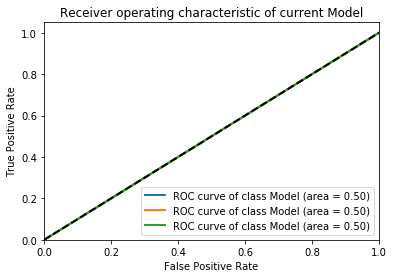

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric=['auc', 'error'],
              gamma=None, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001,
              max_delta_step=None, max_depth=6, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbose=True, verbosity=None)  -- control 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:56:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


          negative  neutral  positive
negative         2        0        22
neutral          1        0        38
positive         4        3       927


              precision    recall  f1-score   support

           0       0.29      0.08      0.13        24
           1       0.00      0.00      0.00        39
           2       0.94      0.99      0.97       934

    accuracy                           0.93       997
   macro avg       0.41      0.36      0.36       997
weighted avg       0.89      0.93      0.91       997

0.5196743887323783


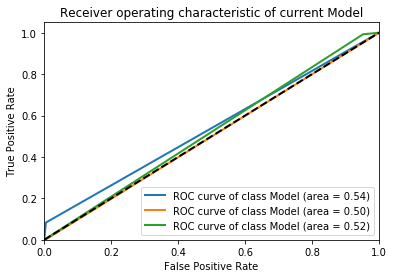

In [54]:
for model in models:
    print(model," -- control","\n","*"*50,"\n")

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.4540758432621388

          negative  neutral  positive
negative        14        6         4
neutral         14       10        15
positive       228      218       488


              precision    recall  f1-score   support

           0       0.05      0.58      0.10        24
           1       0.04      0.26      0.07        39
           2       0.96      0.52      0.68       934

    accuracy                           0.51       997
   macro avg       0.35      0.45      0.28       997
weighted avg       0.90      0.51      0.64       997

0.6079384628294978


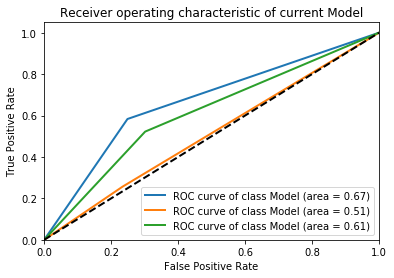

DecisionTreeClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.4457621845202145

          negative  neutral  positive
negative         8        4        12
neutral          7        6        26
positive        58       82       794


              precision    recall  f1-score   support

           0       0.11      0.33      0.16        24
           1       0.07      0.15      0.09        39
           2       0.95      0.85      0.90       934

    accuracy                           0.81       997
   macro avg       0.38      0.45      0.39       997
weighted avg       0.90      0.81      0.85       997

0.6201256710110589


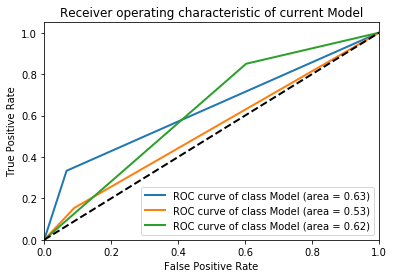

RandomForestClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

Balanced Accuracy Score:0.35896978348798475

          negative  neutral  positive
negative         2        0        22
neutral          0        0        39
positive         6        0       928


              precision    recall  f1-score   support

           0       0.25      0.08      0.12        24
           1       0.00      0.00      0.00        39
           2       0.94      0.99      0.97       934

    accuracy                           0.93       997
   macro avg       0.40      0.36      0.36       997
weighted avg       0.89      0.93      0.91       997

0.5127897681854516


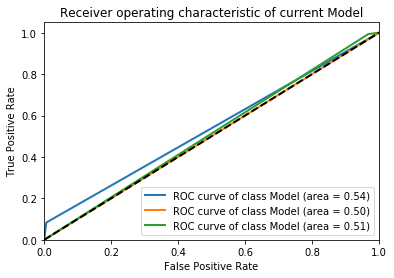

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- oversampled 
 ************************************************** 

[23:43:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old be

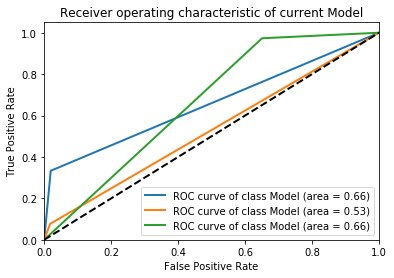

In [ ]:
for model in models:
    print(model," -- oversampled","\n","*"*50,"\n")
    steps = [("o",oversample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.47538617104998265

          negative  neutral  positive
negative        15        5         4
neutral         15       14        10
positive       335      186       413


              precision    recall  f1-score   support

           0       0.04      0.62      0.08        24
           1       0.07      0.36      0.11        39
           2       0.97      0.44      0.61       934

    accuracy                           0.44       997
   macro avg       0.36      0.48      0.27       997
weighted avg       0.91      0.44      0.57       997

0.6093459261818103


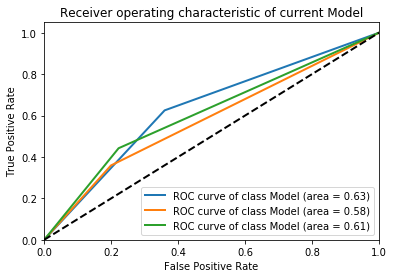

DecisionTreeClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.5239412324530097

          negative  neutral  positive
negative        15        6         3
neutral         11       13        15
positive       148      213       573


              precision    recall  f1-score   support

           0       0.09      0.62      0.15        24
           1       0.06      0.33      0.10        39
           2       0.97      0.61      0.75       934

    accuracy                           0.60       997
   macro avg       0.37      0.52      0.33       997
weighted avg       0.91      0.60      0.71       997

0.6611361671176034


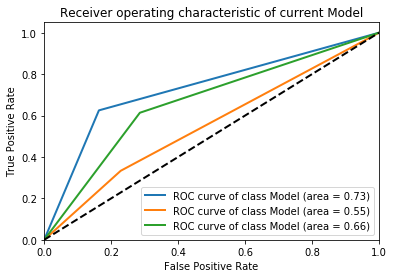

RandomForestClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

Balanced Accuracy Score:0.5128777064001904

          negative  neutral  positive
negative        15        7         2
neutral         15       13        11
positive       117      275       542


              precision    recall  f1-score   support

           0       0.10      0.62      0.18        24
           1       0.04      0.33      0.08        39
           2       0.98      0.58      0.73       934

    accuracy                           0.57       997
   macro avg       0.37      0.51      0.33       997
weighted avg       0.92      0.57      0.69       997

0.6818123193064994


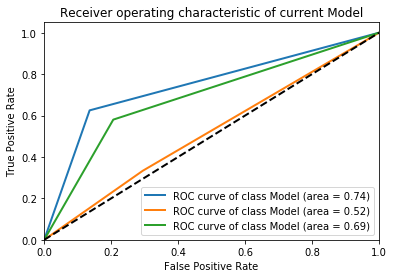

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- undersampled 
 ************************************************** 

[23:48:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old b

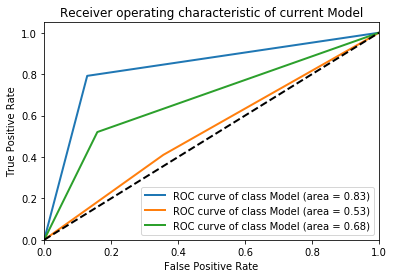

In [ ]:
for model in models:
    print(model," -- undersampled","\n","*"*50,"\n")
    steps = [("o",undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

LogisticRegression(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.4344424312304398

          negative  neutral  positive
negative        16        3         5
neutral         16        7        16
positive       293      214       427


              precision    recall  f1-score   support

           0       0.05      0.67      0.09        24
           1       0.03      0.18      0.05        39
           2       0.95      0.46      0.62       934

    accuracy                           0.45       997
   macro avg       0.34      0.43      0.25       997
weighted avg       0.90      0.45      0.58       997

0.5612892924550905


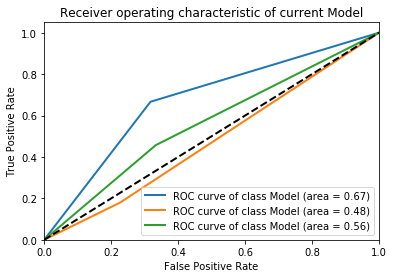

DecisionTreeClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.5173525320741595

          negative  neutral  positive
negative        11        4         9
neutral          7        9        23
positive        74       54       806


              precision    recall  f1-score   support

           0       0.12      0.46      0.19        24
           1       0.13      0.23      0.17        39
           2       0.96      0.86      0.91       934

    accuracy                           0.83       997
   macro avg       0.41      0.52      0.42       997
weighted avg       0.91      0.83      0.86       997

0.6741365035022384


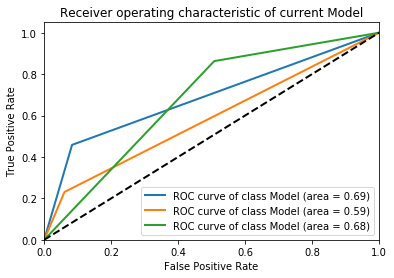

RandomForestClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

Balanced Accuracy Score:0.38817511301451346

          negative  neutral  positive
negative         4        0        20
neutral          0        0        39
positive         2        0       932


              precision    recall  f1-score   support

           0       0.67      0.17      0.27        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.54      0.39      0.41       997
weighted avg       0.90      0.94      0.91       997

0.5307182825168436


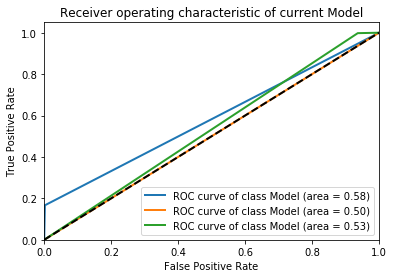

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- over/under 
 ************************************************** 

[23:48:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old beh

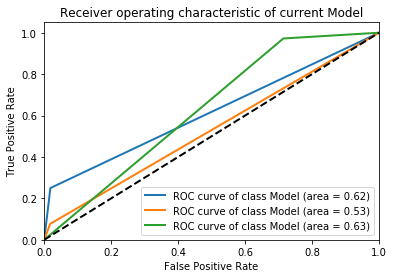

In [ ]:
for model in models:
    print(model," -- over/under","\n","*"*50,"\n")
    steps = [("o",oversample),("u", undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

[23:53:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Balanced Accuracy Score:0.5540868244294369

          negative  neutral  positive
negative        22        2         0
neutral         21       12         6
positive       192      333       409


              precision    recall  f1-score   support

           0       0.09      0.92      0.17        24
           1       0.03      0.31      0.06        39
           2       0.99      0.44      0.61       934

    accuracy                           0.44       997
   macro avg       0.37      0.55      0.28       997
weighted avg       0.93      0.44      0.57       997

0.6680822356728396


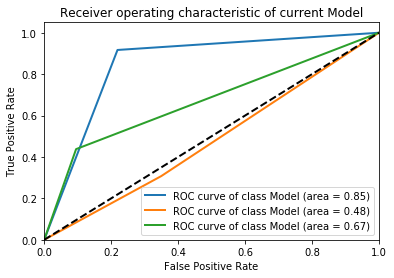

In [ ]:
steps = [("o",undersample),('model', VotingClassifier([("XGB", XGBClassifier(n_estimators=1000,max_depth=6)),("FRST", RandomForestClassifier(class_weight="balanced"))]))]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
show_metrics(y_test,preds)

In [38]:
NN= Sequential()
NN.add(Flatten())
NN.add(Dense(128, activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(256,activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(512,activation="relu"))

NN.add(Dropout(.4))
NN.add(Dense(3,activation="softmax"))
NN.compile(optimizer="adam",loss="categorical_crossentropy")

In [39]:
X,y = oversample.fit_resample(X_train,y_train)

NN.fit(X,y,epochs=100)

Epoch 1/100
11082/11082 [==============================] - 3s 251us/sample - loss: 32.1977
Epoch 2/100
11082/11082 [==============================] - 2s 183us/sample - loss: 32.2362
Epoch 3/100
11082/11082 [==============================] - 2s 186us/sample - loss: 32.2362
Epoch 4/100
11082/11082 [==============================] - 2s 188us/sample - loss: 32.2362
Epoch 5/100
11082/11082 [==============================] - 2s 193us/sample - loss: 32.2362
Epoch 6/100
11082/11082 [==============================] - 2s 184us/sample - loss: 32.2362
Epoch 7/100
11082/11082 [==============================] - 2s 189us/sample - loss: 32.2362
Epoch 8/100
10176/11082 [==========================>...] - ETA: 0s - loss: 32.3692

KeyboardInterrupt: 

In [43]:
preds_array = NN.predict(X_test)
pred_list = []
for i,pred in enumerate(preds_array):
    pred_list.append(pred.argmax())

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0        0       934


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.94      0.91       997

0.5


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


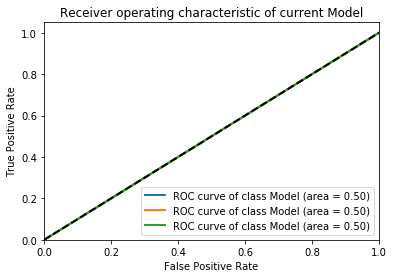

In [44]:
show_metrics(y_test,pred_list)

In [45]:
X_train.shape,y_train.shape

((3942, 1009), (3942,))

In [46]:
import tensorflow as tf
print(tf.__version__)

1.13.1


Epoch 1/5
11082/11082 [==============================] - 531s 48ms/sample - loss: 1.0922 - acc: 0.3834
Epoch 2/5
11082/11082 [==============================] - 539s 49ms/sample - loss: 1.0563 - acc: 0.4591
Epoch 3/5
11082/11082 [==============================] - 549s 50ms/sample - loss: 1.0204 - acc: 0.4859
Epoch 4/5
11082/11082 [==============================] - 544s 49ms/sample - loss: 0.9690 - acc: 0.5236
Epoch 5/5
11082/11082 [==============================] - 535s 48ms/sample - loss: 0.9064 - acc: 0.5566
          negative  neutral  positive
negative        16        4         4
neutral         12       17        10
positive       296      353       285


              precision    recall  f1-score   support

           0       0.05      0.67      0.09        24
           1       0.05      0.44      0.08        39
           2       0.95      0.31      0.46       934

    accuracy                           0.32       997
   macro avg       0.35      0.47      0.21       997
weigh

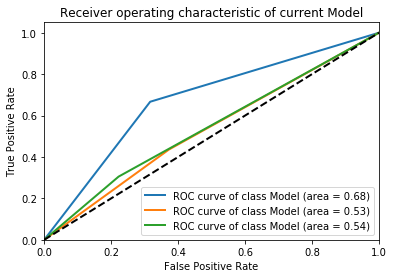

In [40]:
X,y = oversample.fit_resample(X_train,y_train)


y_train2 = label_binarize(y, classes=[0, 1, 2])
epochs = 5
emb_dim = 128
batch_size = 256
model = Sequential()
model.add(Embedding(X.shape[0], emb_dim, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])
model.fit(X, y_train2, epochs=epochs, batch_size=batch_size,workers=6)
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

Epoch 1/20
11082/11082 [==============================] - 332s 30ms/sample - loss: 1.0877 - acc: 0.4005
Epoch 2/20
11082/11082 [==============================] - 331s 30ms/sample - loss: 1.0420 - acc: 0.4699
Epoch 3/20
11082/11082 [==============================] - 327s 29ms/sample - loss: 0.9961 - acc: 0.5002
Epoch 4/20
11082/11082 [==============================] - 326s 29ms/sample - loss: 0.9298 - acc: 0.5348
Epoch 5/20
11082/11082 [==============================] - 325s 29ms/sample - loss: 0.8829 - acc: 0.5633
Epoch 6/20
11082/11082 [==============================] - 327s 29ms/sample - loss: 0.8305 - acc: 0.5930
Epoch 7/20
11082/11082 [==============================] - 326s 29ms/sample - loss: 0.7905 - acc: 0.6153
Epoch 8/20
11082/11082 [==============================] - 326s 29ms/sample - loss: 0.7576 - acc: 0.6369
Epoch 9/20
11082/11082 [==============================] - 326s 29ms/sample - loss: 0.7475 - acc: 0.6382
Epoch 10/20
11082/11082 [==============================] - 327s 

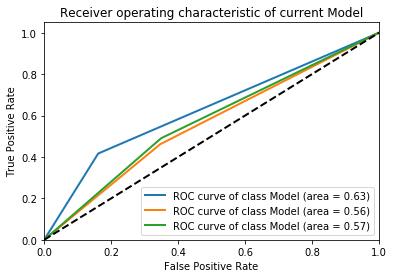

In [41]:

X,y = oversample.fit_resample(X_train,y_train)


y_train2 = label_binarize(y, classes=[0, 1, 2])
epochs = 20
emb_dim = 128
batch_size = 256
model = Sequential()
model.add(Embedding(X.shape[0], emb_dim, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.7))
model.add(GRU(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])
model.fit(X, y_train2, epochs=epochs, batch_size=batch_size,workers=6)
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

<function sklearn.metrics._ranking.auc(x, y)>